In [410]:
# Importing Important Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
 

# For test train split
from sklearn.model_selection import train_test_split,cross_val_score

# For feature scaling
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# For logistic regression
import statsmodels.api as sm

from xgboost import XGBClassifier

#Scorer
from sklearn.metrics import make_scorer

# For RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics

# To check the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import precision_score, recall_score,roc_auc_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [450]:
# Load Training Data
train_data_raw = pd.read_csv('final_train.csv')
train_data_raw.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Diabetes_beta,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes_alpha,Outcome
0,1,10,115,98,0,0.427693,0,24.000000,1.022000,34,-0.124760,0
1,2,3,158,76,36,252.585650,245,31.600000,0.851000,28,34.811119,1
2,3,1,146,70,0,0.836085,0,38.133490,0.322014,30,-0.543023,1
3,4,0,130,61,33,235.208054,161,34.849096,0.612714,25,22.780794,1
4,5,4,134,70,0,0.163228,0,30.650459,1.057743,23,-0.897223,1


In [451]:
# Info of the data
print(train_data_raw.shape)
train_data_raw.info()

# No null values as such but might hve to look for redundent values later

(1152, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        1152 non-null   int64  
 1   Pregnancies               1152 non-null   int64  
 2   Glucose                   1152 non-null   int64  
 3   BloodPressure             1152 non-null   int64  
 4   SkinThickness             1152 non-null   int64  
 5   Diabetes_beta             1152 non-null   float64
 6   Insulin                   1152 non-null   int64  
 7   BMI                       1152 non-null   float64
 8   DiabetesPedigreeFunction  1152 non-null   float64
 9   Age                       1152 non-null   int64  
 10  Diabetes_alpha            1152 non-null   float64
 11  Outcome                   1152 non-null   int64  
dtypes: float64(4), int64(8)
memory usage: 108.1 KB


In [452]:
# Describe the dataset
train_data_raw.describe()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Diabetes_beta,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes_alpha,Outcome
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,576.500000,3.509549,119.850694,68.087674,20.802951,147.483041,76.530382,31.740143,0.469615,32.301215,10.473392,0.348958
std,332.698061,2.959896,29.938314,18.357445,15.385864,108.354730,102.740168,7.488215,0.286564,10.739166,14.682415,0.476848
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.010754,0.000000,0.000000,0.078000,21.000000,-0.999336,0.000000
25%,288.750000,1.000000,99.000000,63.000000,0.000000,0.893738,0.000000,27.142621,0.268435,24.000000,-0.426920,0.000000
50%,576.500000,3.000000,115.000000,70.000000,23.000000,161.821481,44.000000,31.658675,0.395264,29.000000,5.833615,0.000000
75%,864.250000,5.000000,137.250000,78.000000,32.000000,224.781685,128.000000,36.006685,0.599228,39.000000,17.779236,1.000000
max,1152.000000,17.000000,199.000000,122.000000,99.000000,693.571208,706.000000,67.100000,2.420000,72.000000,100.518992,1.000000


In [453]:
# Split the data into test and train
Y_raw = train_data_raw['Outcome']
X_raw = train_data_raw.drop('Outcome',axis = 1)
train_x,test_x,train_y,test_y = train_test_split(X_raw,Y_raw,test_size = 0.2,random_state = 200)

train_data = pd.concat([train_x,train_y],axis = 1).reset_index(drop = True)
test_data = pd.concat([test_x,test_y],axis = 1).reset_index(drop = True)

print(train_data.shape)
print(test_data.shape)

(921, 12)
(231, 12)


In [454]:
# Function to plot boxplot for univariate analysis
sns.set_theme(style="whitegrid")
def univariate_box_plot(series):
    sns.boxplot(y = series,palette="Set3")
    
# Function to plot pairwise boxplot-Variable vs outcome
def pairwise_box_plot(series1,series2):
    sns.boxplot(x = series1,y = series2,palette="Set3")
    
# Function for Outlier Treatment, Return the upper cutoff and the lower cutoff
def upper_lower_wisker(series):
    median = np.percentile(series,50)
    lower_quartile = np.percentile(series,25)
    upper_quartile = np.percentile(series,75)
    IQR = upper_quartile - lower_quartile
    lower_wisker = lower_quartile  - 1.5*IQR
    upper_wisker = upper_quartile + 1.5*IQR
    return (upper_wisker,lower_wisker)

#Function to plot distplot
def univariate_dist_plot(series):
    sns.distplot(series,bins = 20)
    
# Function to plot Scatterplot
def univariate_scatter_plot(x,y):
    sns.scatterplot(x,y,palette = "Set3")
    
# Function to plot barplot
def univariate_bar_plot(x,y):
    sns.barplot(x,y)
    
# Function to find the Risk of Diabetes for each value of categorical variable    
def crosstab_plot_func(series,outcome):
    crosstab = pd.crosstab(series, outcome).reset_index()
    crosstab.columns = ['Num_Value','No','Yes']
    crosstab['diab_per'] = 100*crosstab['Yes']/(crosstab['Yes']+crosstab['No'])
    univariate_bar_plot(x = crosstab['Num_Value'],y = crosstab['diab_per'])

# EDA STARTS

## UNIVARIATE ANALYSIS

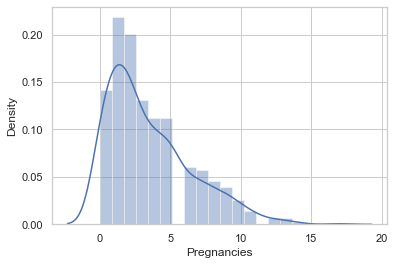

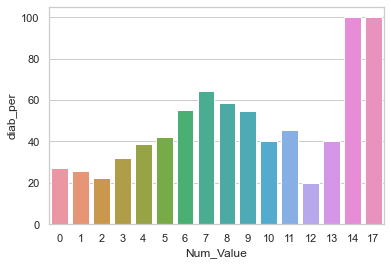

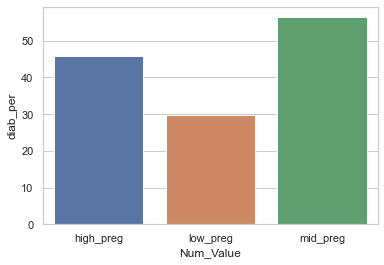

In [455]:
#Pregnancy


#Visualise the density and boxplot
univariate_dist_plot(train_data['Pregnancies'])
plt.show()


# Check the % of 0 and 1 for each pregnancy value to decide bin cutoff
crosstab_plot_func(train_data['Pregnancies'],train_data['Outcome'])
plt.show()

# Trends shows that the risk of diabetes increases with increase in pregnancy numbers, highest between 6-10 pregnancies

#Lets break the data into 3 bins, 0-5, 6-10 and >10
def pregnancies_bins(x):
    if(x<=5):
        return 'low_preg'
    elif(x<=10):
        return 'mid_preg'
    else:
        return 'high_preg'

train_data['pregancies_new'] = train_data['Pregnancies'].apply(lambda x:pregnancies_bins(x))

# Check the risk of diabetes in the newly created bins
crosstab_plot_func(train_data['pregancies_new'],train_data['Outcome'])
plt.show()

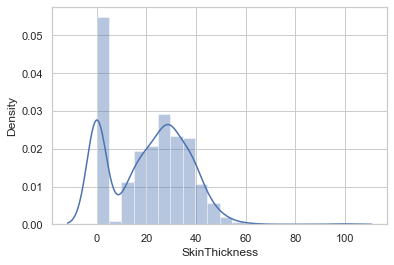

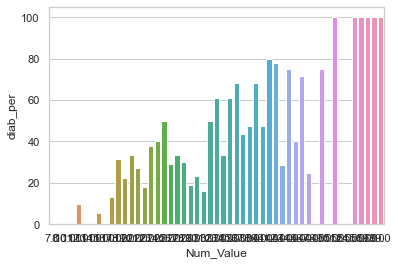

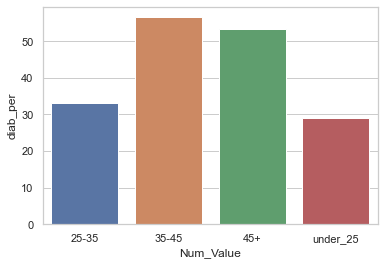

In [456]:
#SkinThickness


#Visualise the density and boxplot
univariate_dist_plot(train_data['SkinThickness'])
plt.show()

# Zero for skin thickness is not possible, lets replace it with median of the series
median = np.percentile(train_data['SkinThickness'],50)
train_data['SkinThickness'] = train_data['SkinThickness'].apply(lambda x:median if x==0 else x)

# Check the % of 0 and 1 for each pregnancy value to decide bin cutoff
crosstab_plot_func(train_data['SkinThickness'],train_data['Outcome'])
plt.show()

# Trends shows that the risk of diabetes increases with increase in skin thickness generally, highest between 35-45 thickness

#Lets break the data into 4 bins, <25,25-35,35-45,>45 age group within each

def skin_thickness_bins(thickness):
    if(thickness<=25):
        return 'under_25'
    elif(thickness<=35):
        return '25-35'
    elif(thickness<=45):
        return '35-45'
    else:
        return '45+'
    

train_data['skin_thickness_new'] = train_data['SkinThickness'].apply(lambda x:skin_thickness_bins(x))

# Check the risk of diabetes in the newly created bins
crosstab_plot_func(train_data['skin_thickness_new'],train_data['Outcome'])
plt.show()

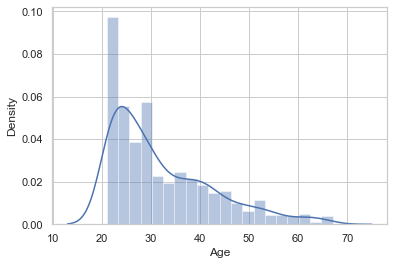

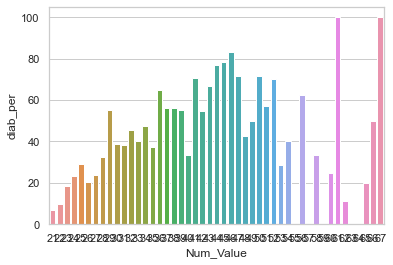

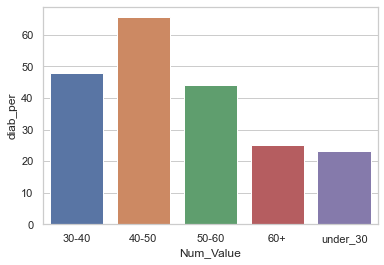

In [457]:
#Age


#Visualise the density and boxplot
univariate_dist_plot(train_data['Age'])
plt.show()


# Check the % of 0 and 1 for each pregnancy value to decide bin cutoff
crosstab_plot_func(train_data['Age'],train_data['Outcome'])
plt.show()

# Trends shows that the risk of diabetes increases with increase in age numbers, highest between 30-50 years

#Lets break the data into 5 bins, 21-30,31-40,41-50,51-60,60+ age group within each

def age_bins(age):
    if(age<=30):
        return 'under_30'
    elif(age<=40):
        return '30-40'
    elif(age<=50):
        return '40-50'
    elif(age<=60):
        return '50-60'
    else:
        return '60+'
    

train_data['age_new'] = train_data['Age'].apply(lambda x:age_bins(x))

# Check the risk of diabetes in the newly created bins
crosstab_plot_func(train_data['age_new'],train_data['Outcome'])
plt.show()

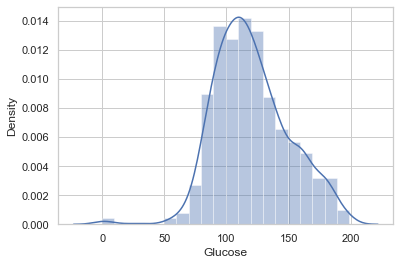

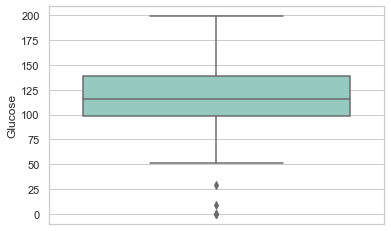

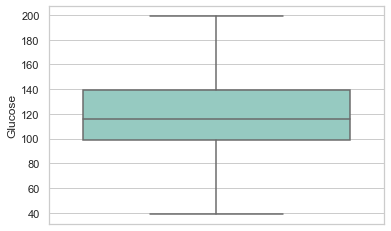

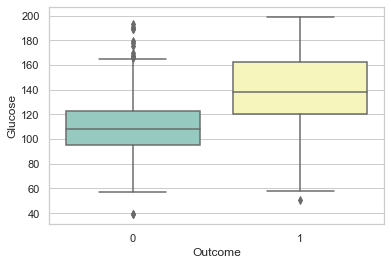

In [458]:
# Glucose

#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['Glucose'])
plt.show()
univariate_box_plot(train_data['Glucose'])
plt.show()

# Glucose levels can't be zero, replace zero values with data median 
# Check for upper lower wiskers and cap the data to those values
median = np.percentile(train_data['Glucose'],50)
train_data['Glucose'] = train_data['Glucose'].apply(lambda x:median if x==0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['Glucose'])
train_data['Glucose'] = train_data['Glucose'].apply(lambda x:upper_cap if x>=upper_cap else x)
train_data['Glucose'] = train_data['Glucose'].apply(lambda x:lower_cap if x<=lower_cap else x)
univariate_box_plot(train_data['Glucose'])
plt.show()


# Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['Glucose'])
plt.show()

# People with Diabetes have high glucose levels as expected, but there are certain high glucose level individual with no diabetes

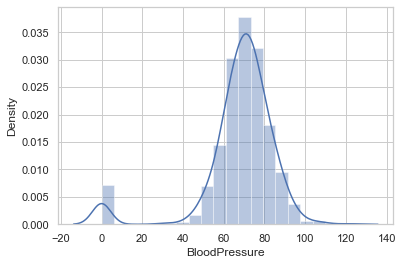

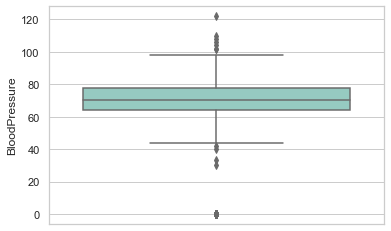

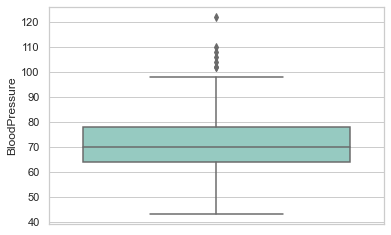

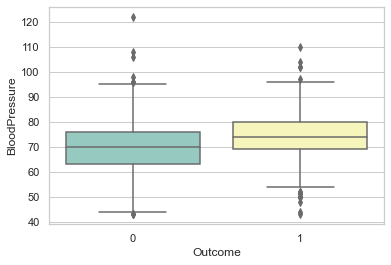

In [459]:
# BloodPressure

#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['BloodPressure'])
plt.show()
univariate_box_plot(train_data['BloodPressure'])
plt.show()

# BP levels can't be zero, replace zero values with data median 
# Check for only lower wiskers and cap the data to those values(because high BP can be correlated to blood glucose)
median = np.percentile(train_data['BloodPressure'],50)
train_data['BloodPressure'] = train_data['BloodPressure'].apply(lambda x:median if x==0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['BloodPressure'])
train_data['BloodPressure'] = train_data['BloodPressure'].apply(lambda x:lower_cap if x<=lower_cap else x)
univariate_box_plot(train_data['BloodPressure'])
plt.show()


# Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['BloodPressure'])
plt.show()

# People with Diabetes have high BP levels as expected, but there are certain high BP level individual with no diabetes which can be expected

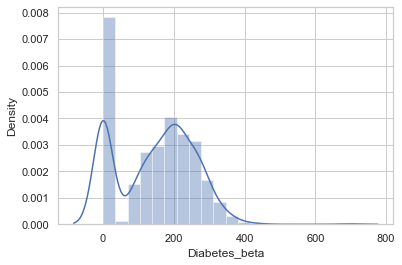

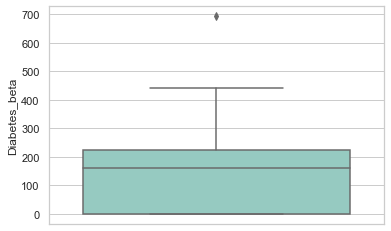

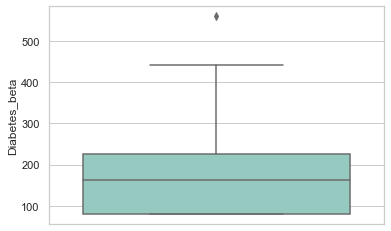

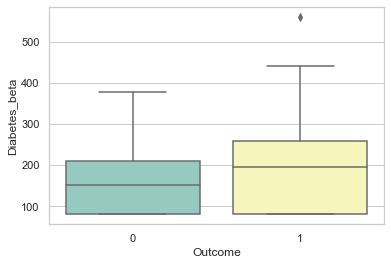

In [460]:
# Diabetes_beta


#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['Diabetes_beta'])
plt.show()
univariate_box_plot(train_data['Diabetes_beta'])
plt.show()


# Since the lower range values are redundent, as can be seen from distplot, cap the lower values to 80 and higher range values to upper cap
(upper_cap,lower_cap) = upper_lower_wisker(train_data['Diabetes_beta'])
lower_cap = 80
train_data['Diabetes_beta'] = train_data['Diabetes_beta'].apply(lambda x:upper_cap if x>=upper_cap else x)
train_data['Diabetes_beta'] = train_data['Diabetes_beta'].apply(lambda x:lower_cap if x<=lower_cap else x)
univariate_box_plot(train_data['Diabetes_beta'])
plt.show()


 # Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['Diabetes_beta'])
plt.show()

# People with Diabetes have high Diabetes Beta levels

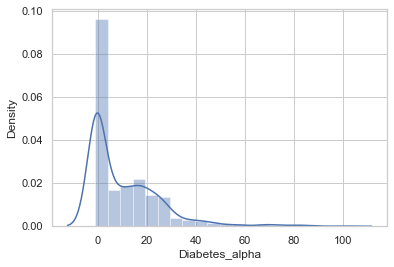

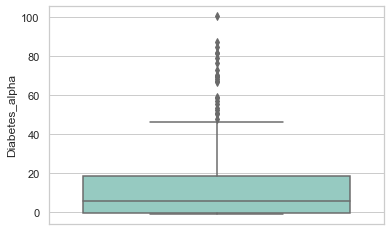

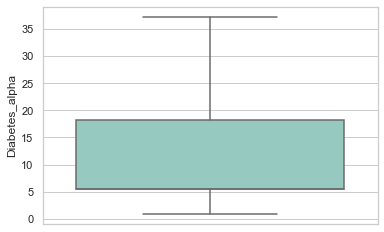

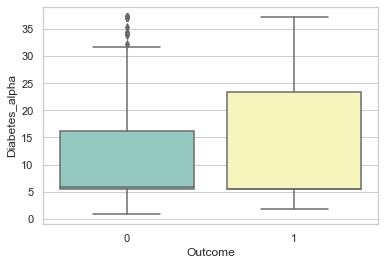

In [461]:
# Diabetes_alpha


#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['Diabetes_alpha'])
plt.show()
univariate_box_plot(train_data['Diabetes_alpha'])
plt.show()


# Since the lower range values are redundent, cap the values lower than 0 to median
# Cap the upper outlier to upper wisker
median = np.percentile(train_data['Diabetes_alpha'],50)
train_data['Diabetes_alpha'] = train_data['Diabetes_alpha'].apply(lambda x:median if x<=0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['Diabetes_alpha'])
train_data['Diabetes_alpha'] = train_data['Diabetes_alpha'].apply(lambda x:upper_cap if x>=upper_cap else x)
train_data['Diabetes_alpha'] = train_data['Diabetes_alpha'].apply(lambda x:lower_cap if x<=lower_cap else x)
univariate_box_plot(train_data['Diabetes_alpha'])
plt.show()


  # Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['Diabetes_alpha'])
plt.show()

# People with Diabetes have high Diabetes Alpha levels
# Can choose to drop this column later since almost 25% values are redundent

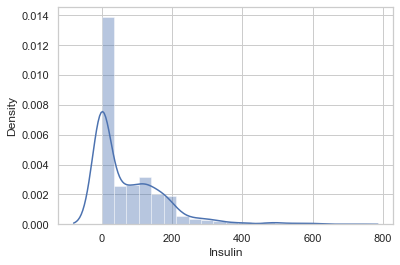

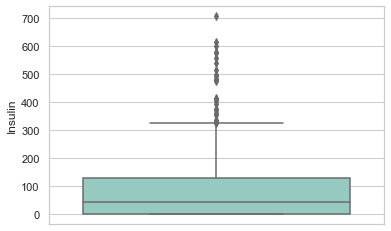

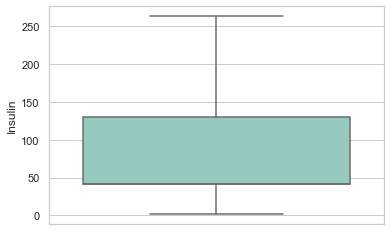

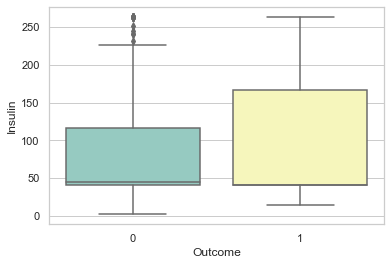

In [462]:
#Insulin

#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['Insulin'])
plt.show()
univariate_box_plot(train_data['Insulin'])
plt.show()

# Insulin levels can't be zero, replace zero values with data median 
# Check for only lower and upper wiskers and cap the data to those values
median = np.percentile(train_data['Insulin'],50)
train_data['Insulin'] = train_data['Insulin'].apply(lambda x:median if x<=0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['Insulin'])
train_data['Insulin'] = train_data['Insulin'].apply(lambda x:lower_cap if x<=lower_cap else x)
train_data['Insulin'] = train_data['Insulin'].apply(lambda x:upper_cap if x>=upper_cap else x)
univariate_box_plot(train_data['Insulin'])
plt.show()


# Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['Insulin'])
plt.show()

# People with Diabetes have high Insulin levels as expected
# Insulin has almost 30% redundent values, can choose to drop this column later

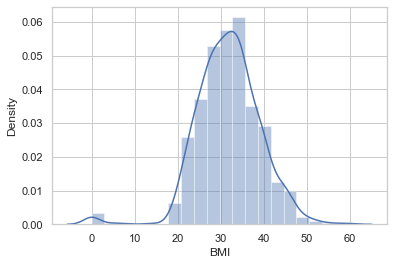

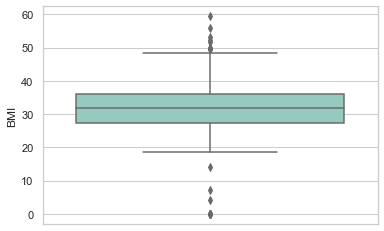

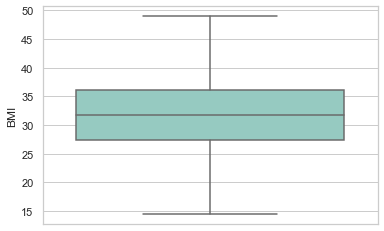

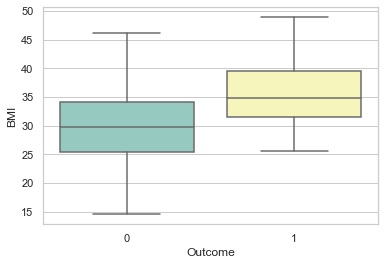

In [463]:
#BMI


#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['BMI'])
plt.show()
univariate_box_plot(train_data['BMI'])
plt.show()

# BMI levels can't be zero, replace zero values with data median 
# Check for only lower and upper wiskers and cap the data to those values
median = np.percentile(train_data['BMI'],50)
train_data['BMI'] = train_data['BMI'].apply(lambda x:median if x<=0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['BMI'])
train_data['BMI'] = train_data['BMI'].apply(lambda x:lower_cap if x<=lower_cap else x)
train_data['BMI'] = train_data['BMI'].apply(lambda x:upper_cap if x>=upper_cap else x)
univariate_box_plot(train_data['BMI'])
plt.show()


# Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['BMI'])
plt.show()

# People with Diabetes have high Insulin levels as expected

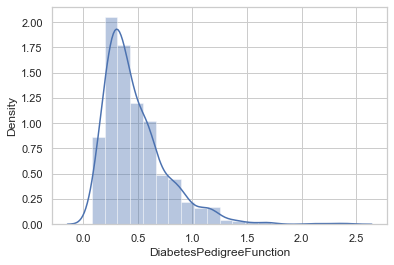

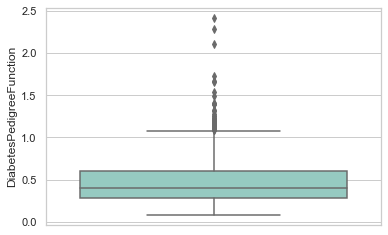

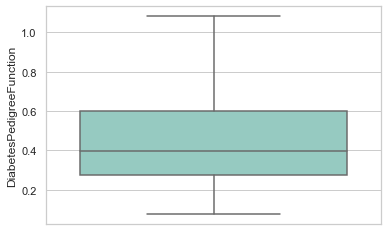

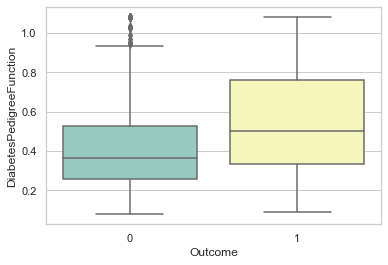

In [464]:
#DiabetesPedigreeFunction


#plot the boxplot to see the percentile distribution
univariate_dist_plot(train_data['DiabetesPedigreeFunction'])
plt.show()
univariate_box_plot(train_data['DiabetesPedigreeFunction'])
plt.show()

#Cap the values to upper and lower wiskers
(upper_cap,lower_cap) = upper_lower_wisker(train_data['DiabetesPedigreeFunction'])
train_data['DiabetesPedigreeFunction'] = train_data['DiabetesPedigreeFunction'].apply(lambda x:lower_cap if x<=lower_cap else x)
train_data['DiabetesPedigreeFunction'] = train_data['DiabetesPedigreeFunction'].apply(lambda x:upper_cap if x>=upper_cap else x)
univariate_box_plot(train_data['DiabetesPedigreeFunction'])
plt.show()


# Check the distribution with respect to outcome
pairwise_box_plot(train_data['Outcome'],train_data['DiabetesPedigreeFunction'])
plt.show()

# People with Diabetes have high DiabetesPedigreeFunctions levels

## BIVARIATE ANALYSIS

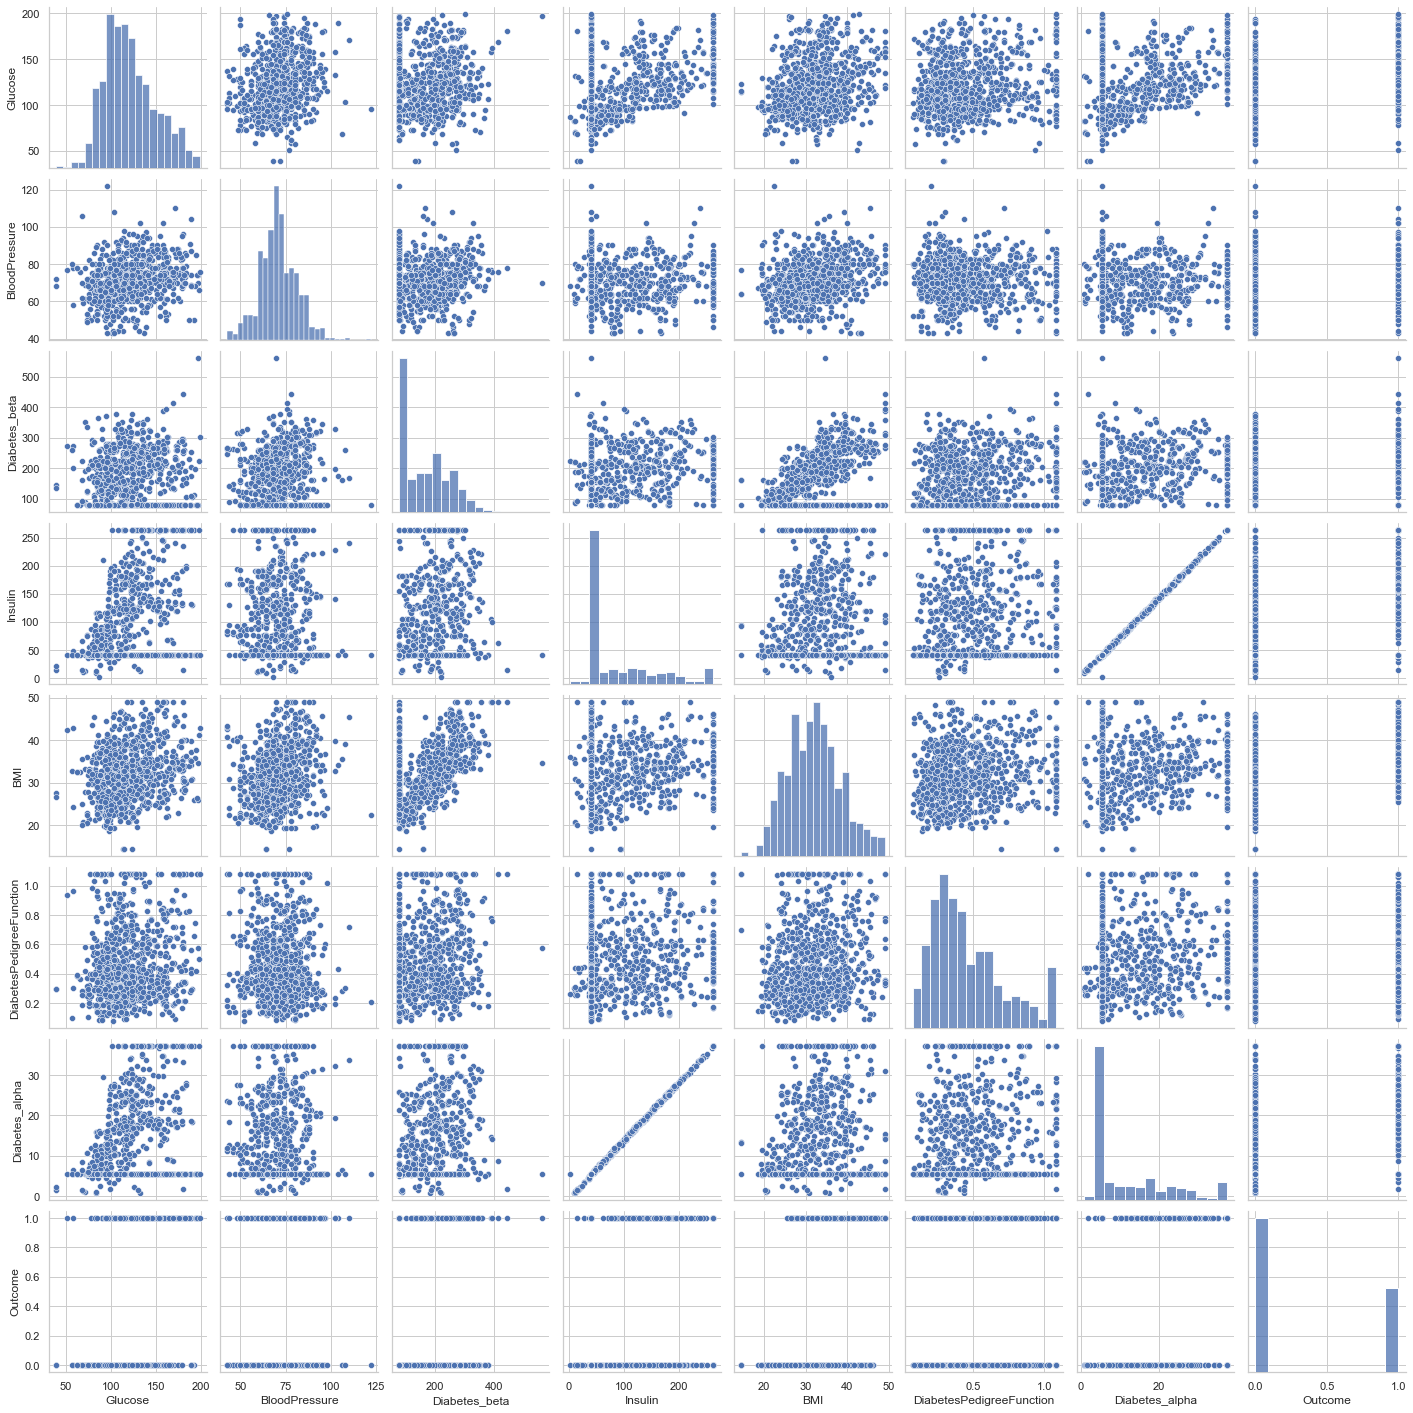

In [465]:
# Lets draw a pairplot to understand the relation ship between different variables
# Numerical Variables
train_data_num = train_data[['Glucose','BloodPressure','Diabetes_beta','Insulin','BMI','DiabetesPedigreeFunction','Diabetes_alpha','Outcome']]

sns.pairplot(train_data_num)

In [466]:
# Plot the heatmap
train_data_num.corr()

,Glucose,BloodPressure,Diabetes_beta,Insulin,BMI,DiabetesPedigreeFunction,Diabetes_alpha,Outcome
Glucose,1.000000,0.252750,0.102858,0.305287,0.270238,0.135310,0.306420,0.498495
BloodPressure,0.252750,1.000000,0.089949,-0.024153,0.261130,0.002255,-0.025381,0.178734
Diabetes_beta,0.102858,0.089949,1.000000,0.391162,0.542902,0.234844,0.391483,0.173452
Insulin,0.305287,-0.024153,0.391162,1.000000,0.224148,0.246867,0.999654,0.163351
BMI,0.270238,0.261130,0.542902,0.224148,1.000000,0.147657,0.225389,0.420500
DiabetesPedigreeFunction,0.135310,0.002255,0.234844,0.246867,0.147657,1.000000,0.247399,0.267900
Diabetes_alpha,0.306420,-0.025381,0.391483,0.999654,0.225389,0.247399,1.000000,0.165026
Outcome,0.498495,0.178734,0.173452,0.163351,0.420500,0.267900,0.165026,1.000000


In [467]:
#Diabetes alpha and insulin are directly correlated, lets remove Diabetes_alpha from model to avoid multi colinearity
#Diabetes beta and BMI are directly correlated, lets remove Diabetes_beta also from model to avoid multi colinearity
# Outcome his mostly correlated with Glucose and BMI

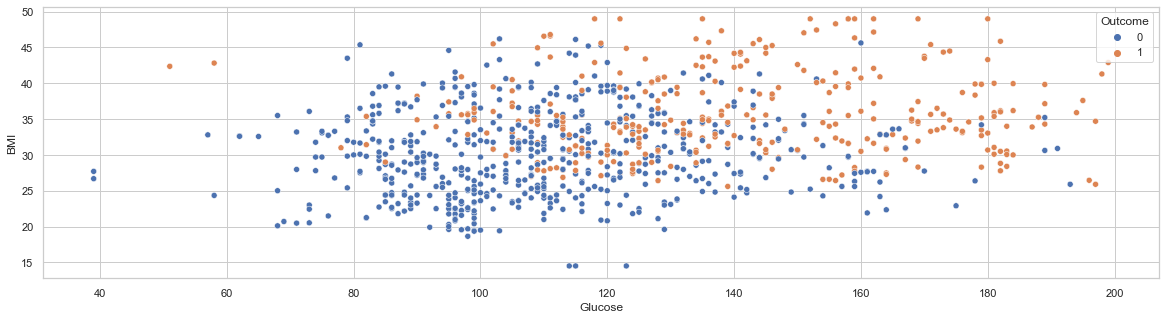

In [468]:
# Lets plot 3 variables at a time to understand the pattern better
# I will consider Glucose, BMI and the categorical variables
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['Glucose'],y = train_data['BMI'],hue = train_data['Outcome'])
plt.show()
# High BMI and High Glucose means Diabetes

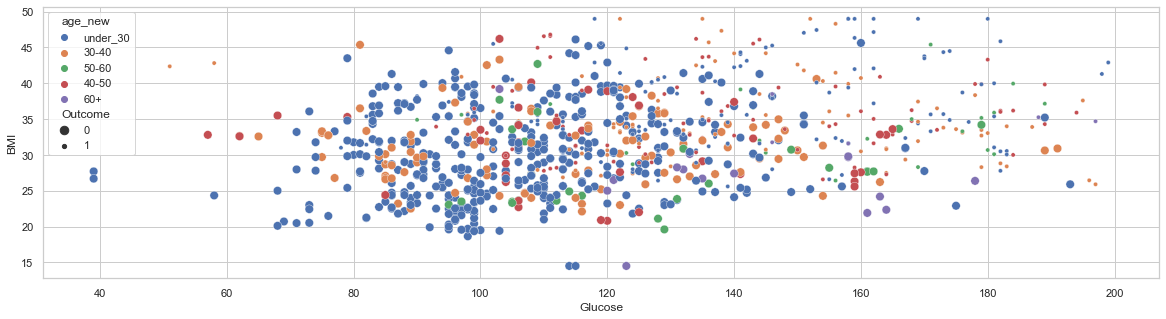

In [469]:
# Consider Age
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['Glucose'],y = train_data['BMI'],hue = train_data['age_new'],size = train_data['Outcome'])
plt.show()
# Age is not that good differentiator

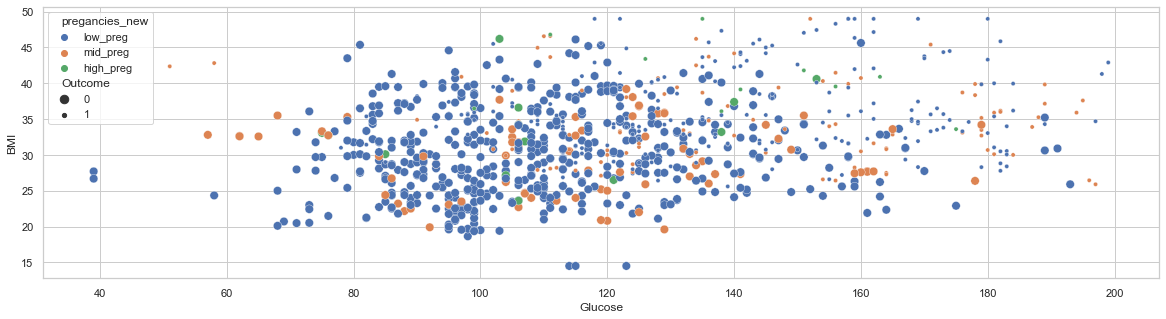

In [470]:
# Consider Pregnancy
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['Glucose'],y = train_data['BMI'],hue = train_data['pregancies_new'],size = train_data['Outcome'])
plt.show()
# High and Mid Pregnancy People have diabetes

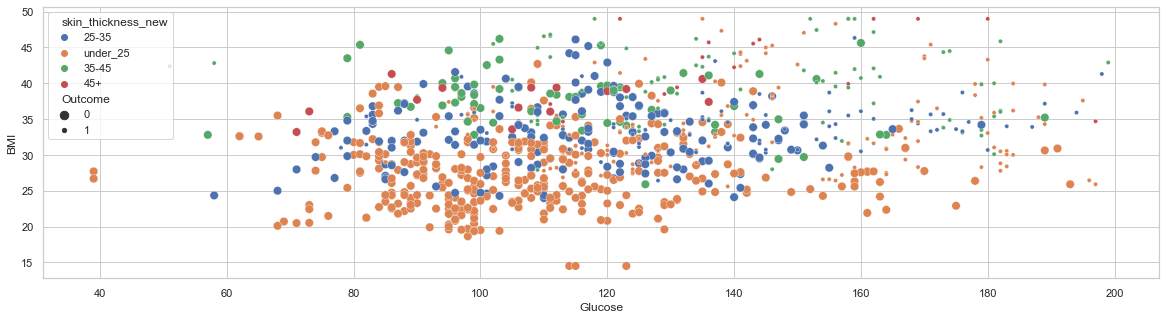

In [471]:
# Consider Skin Thickness
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['Glucose'],y = train_data['BMI'],hue = train_data['skin_thickness_new'],size = train_data['Outcome'])
plt.show()
# Not that impactful

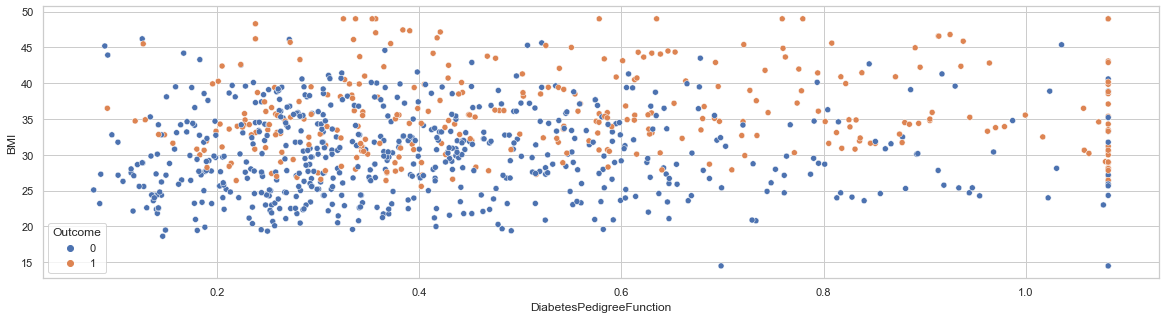

In [472]:
# Consider BMI and DiabetesPedigreeFunction
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['DiabetesPedigreeFunction'],y = train_data['BMI'],hue = train_data['Outcome'])
plt.show()
# As the function value increases, the risk of diabetes increases

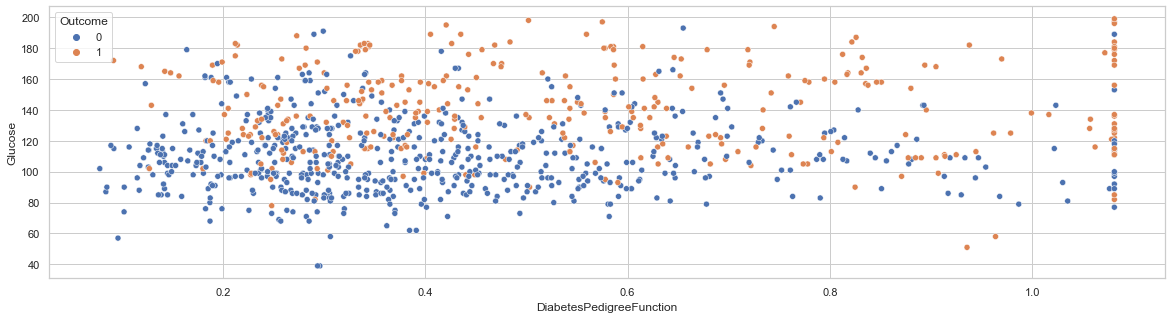

In [473]:
# Consider Glucose and DiabetesPedigreeFunction
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['DiabetesPedigreeFunction'],y = train_data['Glucose'],hue = train_data['Outcome'])
plt.show()
# As the function value increases, the risk of diabetes increases

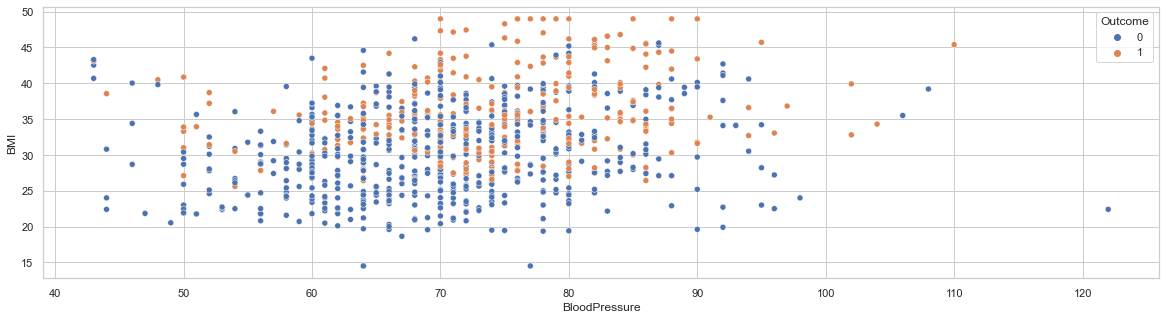

In [474]:
# Consider BMI and BloodPressure
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['BloodPressure'],y = train_data['BMI'],hue = train_data['Outcome'])
plt.show()
# Not much impact of Blood Pressure directly

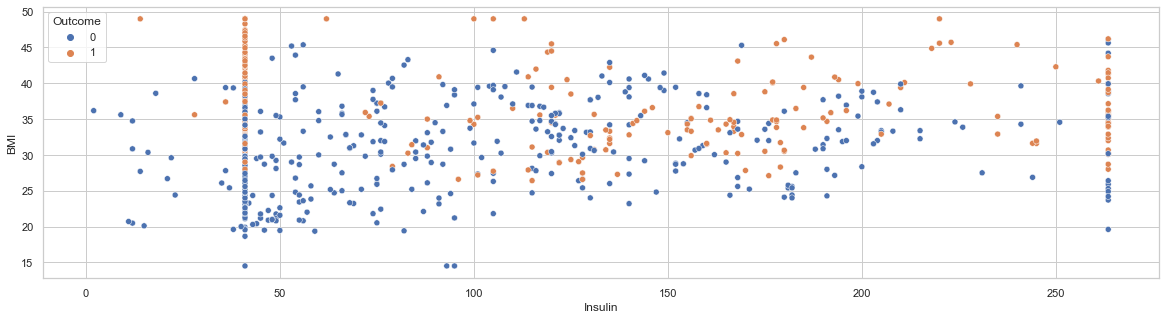

In [475]:
# Consider BMI and Insulin
plt.figure(figsize=(20,5))
sns.scatterplot(x = train_data['Insulin'],y = train_data['BMI'],hue = train_data['Outcome'])
plt.show()
# Not much impact of Insulin Directly

In [476]:
# Select final variables for model selection
X_Train = train_data[['Glucose','BloodPressure','Insulin','BMI','DiabetesPedigreeFunction','pregancies_new','skin_thickness_new','age_new']]
Y_Train = train_data['Outcome']

In [477]:
#Standardisation
#Standard Scaler
scaler = StandardScaler()
num_cols = ['Glucose','BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
X_Train[num_cols] = scaler.fit_transform(X_Train[num_cols])
X_Train.head()

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,pregancies_new,skin_thickness_new,age_new
0,-0.200499,-0.018669,0.583049,0.870564,0.439582,low_preg,25-35,under_30
1,-1.064363,0.458957,-0.236501,-0.035300,-0.517129,low_preg,25-35,under_30
2,-0.787926,-0.209720,-0.719450,0.571171,-0.942552,low_preg,under_25,30-40
3,0.559701,-0.114195,-0.719450,0.174436,-1.170404,low_preg,35-45,under_30
4,-0.787926,1.223158,-0.909702,0.547243,-0.059159,low_preg,under_25,under_30


In [478]:
# Creating dummy for categorical variables
# Converting into dummy variables for categorical varibales with more than 2 unique values
dummy_list = ['pregancies_new','skin_thickness_new','age_new']
dummy_var = pd.get_dummies(X_Train[dummy_list], drop_first = True)

# Adding to dataframe
X_Train = pd.concat([X_Train, dummy_var], axis=1).reset_index(drop = True)
X_Train.drop(dummy_list, axis = 1, inplace =  True)
print(X_Train.shape)
X_Train.head()

(921, 14)


,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,pregancies_new_low_preg,pregancies_new_mid_preg,skin_thickness_new_35-45,skin_thickness_new_45+,skin_thickness_new_under_25,age_new_40-50,age_new_50-60,age_new_60+,age_new_under_30
0,-0.200499,-0.018669,0.583049,0.870564,0.439582,1,0,0,0,0,0,0,0,1
1,-1.064363,0.458957,-0.236501,-0.035300,-0.517129,1,0,0,0,0,0,0,0,1
2,-0.787926,-0.209720,-0.719450,0.571171,-0.942552,1,0,0,0,1,0,0,0,0
3,0.559701,-0.114195,-0.719450,0.174436,-1.170404,1,0,1,0,0,0,0,0,1
4,-0.787926,1.223158,-0.909702,0.547243,-0.059159,1,0,0,0,1,0,0,0,1


# Model Building Starts



In [479]:
# Functions to find confusion metrics and F1 Score
# Confusion matrix 

def confusion_matrix_func(predicted,actual,cutoff):
    predicted = np.where(predicted>cutoff,1,0)
    confusion_matrix = metrics.confusion_matrix(actual, predicted )
    print(confusion_matrix)

    # Checking other metrics
    TP = confusion_matrix[1,1] # true positive 
    TN = confusion_matrix[0,0] # true negatives
    FP = confusion_matrix[0,1] # false positives
    FN = confusion_matrix[1,0] # false negatives

    # Checking the overall accuracy.
    print("Accuracy: ",metrics.accuracy_score(actual, predicted))
    # Checking the sensitivity of the model
#     print("Sensitivity: ",TP / float(TP+FN))
#     # Calculating specificity
#     print("Specificity: ",TN / float(TN+FP))
#     # Calculating false postive rate - predicting converted rate when lead actually did not get converted
#     print("False Positive Rate: ",FP/ float(TN+FP))
#     # Calculating positive predictive value 
#     print ("Positive Predictive Value: ",TP / float(TP+FP))
#     # Calculating negative predictive value
#     print ("Negative Predictive Value: ",TN / float(TN+ FN))
#     #AUC Score
#     print("ROC_AUC_Score:",roc_auc_score(actual,predicted))
    #Recall Score
    print("Recall_Score:",recall_score(actual,predicted))
    #Precsion Score
    print("Precision_Score:",precision_score(actual,predicted))
    #F1 Score
    print("F1 Score",(f1_score(actual,predicted)))

In [480]:
# F1 Score Optimisation

def f1_score_optimisation(predicted,actual):
    cutoff  = np.arange(0,1,0.05)
    f1_list = []
    for c in cutoff:
        predicted_binary = np.where(predicted>c,1,0)
        f1_list.append((f1_score(actual,predicted_binary),c))
    return max(f1_list)

In [481]:
# Logistic Regression
lr_model = LogisticRegression(random_state = 0,class_weight = 'balanced')
lr_model.fit(X_Train,Y_Train)
# Making predictions on train set
predicted = lr_model.predict_proba(X_Train)[:,1]

# F1 Optimisation
best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = best_cutoff[1])
print(best_cutoff[1])

[[490 106]
 [ 69 256]]
Accuracy:  0.8099891422366993
Recall_Score: 0.7876923076923077
Precision_Score: 0.7071823204419889
F1 Score 0.745269286754003
0.5


In [2]:
#importing library and building model
!pip install catboost
#from catboost import CatBoostRegressor
#model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
#model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

^C


In [482]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_Train,Y_Train)
predicted = knn.predict_proba(X_Train)[:,1]

# F1 Optimisation
best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = best_cutoff[1])
print(best_cutoff[1])

[[573  23]
 [ 37 288]]
Accuracy:  0.9348534201954397
Recall_Score: 0.8861538461538462
Precision_Score: 0.9260450160771704
F1 Score 0.9056603773584906
0.65


In [483]:
# SVM
svc = SVC(kernel='rbf',degree  =1,class_weight = 'balanced',probability = True)
svc.fit(X_Train,Y_Train)
predicted = svc.predict(X_Train)



# F1 Optimisation
best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = best_cutoff[1])
print(best_cutoff[1])

[[512  84]
 [ 43 282]]
Accuracy:  0.8621064060803475
Recall_Score: 0.8676923076923077
Precision_Score: 0.7704918032786885
F1 Score 0.8162083936324167
0.9500000000000001


In [484]:
# Decision Tree Classifier
param_test = {
    'max_depth':[3,5,7,9,10,15,20],
    'min_samples_split':[10,20,30,40,50,100]
}
gsearch = GridSearchCV(estimator = 
DecisionTreeClassifier(
              random_state = 0,
              class_weight = 'balanced'), 
              param_grid = param_test,
              scoring='f1',
              n_jobs=4,
              iid=False, 
              cv=5,
              verbose=10)

gsearch.fit(X_Train,Y_Train)

print('Best Grid Search Parameters :',gsearch.best_params_)
print('Best Grid Search Score : ',gsearch.best_score_)




dt_model = DecisionTreeClassifier(random_state = 0,class_weight = "balanced",max_depth = 5)
dt_model.fit(X_Train,Y_Train)
# Making predictions on train set
predicted = dt_model.predict_proba(X_Train)[:,1]

# F1 Optimisation
best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = best_cutoff[1])
print(best_cutoff[1])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0455s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0437s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1360s.) Setting batch_size=16.


Best Grid Search Parameters : {'max_depth': 9, 'min_samples_split': 10}
Best Grid Search Score :  0.7309247948498099
[[466 130]
 [ 39 286]]
Accuracy:  0.8165038002171553
Recall_Score: 0.88
Precision_Score: 0.6875
F1 Score 0.7719298245614036
0.55


[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 201 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.5s finished


In [485]:
#RandomForestClassifier
param_test = {
    'n_estimators':[100,300,500],
    'max_depth':[3,5,8,10]
}
gsearch = GridSearchCV(estimator = 
RandomForestClassifier(
              class_weight = 'balanced'), 
              param_grid = param_test,
              scoring='f1',
              n_jobs=4,
              iid=False, 
              cv=5,
              verbose=10)

gsearch.fit(X_Train,Y_Train)

print('Best Grid Search Parameters :',gsearch.best_params_)
print('Best Grid Search Score : ',gsearch.best_score_)

rf_model = RandomForestClassifier(random_state = 0,class_weight = "balanced",n_estimators =500 ,max_depth =5)
rf_model.fit(X_Train,Y_Train)
# Making predictions on train set
predicted = rf_model.predict_proba(X_Train)[:,1]

# F1 Optimisation
best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = best_cutoff[1])
print(best_cutoff[1])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    9.2s finished


Best Grid Search Parameters : {'max_depth': 10, 'n_estimators': 500}
Best Grid Search Score :  0.8162140807178622
[[529  67]
 [ 41 284]]
Accuracy:  0.8827361563517915
Recall_Score: 0.8738461538461538
Precision_Score: 0.8091168091168092
F1 Score 0.8402366863905326
0.55


# Consider KNN as the best model for training
# Preprocess the test data to validate results

In [486]:
# Pregnancy
test_data['pregancies_new'] = test_data['Pregnancies'].apply(lambda x:pregnancies_bins(x))
#Skin Thickness
test_data['skin_thickness_new'] = test_data['SkinThickness'].apply(lambda x:skin_thickness_bins(x))
#Age
test_data['age_new'] = test_data['Age'].apply(lambda x:age_bins(x))
#Glucose
median = np.percentile(train_data['Glucose'],50)
test_data['Glucose'] = test_data['Glucose'].apply(lambda x:median if x==0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['Glucose'])
test_data['Glucose'] = test_data['Glucose'].apply(lambda x:upper_cap if x>=upper_cap else x)
test_data['Glucose'] = test_data['Glucose'].apply(lambda x:lower_cap if x<=lower_cap else x)
#BloodPressure
median = np.percentile(train_data['BloodPressure'],50)
test_data['BloodPressure'] = test_data['BloodPressure'].apply(lambda x:median if x==0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['BloodPressure'])
test_data['BloodPressure'] = test_data['BloodPressure'].apply(lambda x:lower_cap if x<=lower_cap else x)
#insulin
median = np.percentile(train_data['Insulin'],50)
test_data['Insulin'] = test_data['Insulin'].apply(lambda x:median if x<=0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['Insulin'])
test_data['Insulin'] = test_data['Insulin'].apply(lambda x:lower_cap if x<=lower_cap else x)
test_data['Insulin'] = test_data['Insulin'].apply(lambda x:upper_cap if x>=upper_cap else x)
#BMI
median = np.percentile(train_data['BMI'],50)
test_data['BMI'] = test_data['BMI'].apply(lambda x:median if x<=0 else x)
(upper_cap,lower_cap) = upper_lower_wisker(train_data['BMI'])
test_data['BMI'] = test_data['BMI'].apply(lambda x:lower_cap if x<=lower_cap else x)
test_data['BMI'] = test_data['BMI'].apply(lambda x:upper_cap if x>=upper_cap else x)
#DiabetesPedigreeFunction
(upper_cap,lower_cap) = upper_lower_wisker(train_data['DiabetesPedigreeFunction'])
test_data['DiabetesPedigreeFunction'] = test_data['DiabetesPedigreeFunction'].apply(lambda x:lower_cap if x<=lower_cap else x)
test_data['DiabetesPedigreeFunction'] = test_data['DiabetesPedigreeFunction'].apply(lambda x:upper_cap if x>=upper_cap else x)

In [487]:
# Select final variables for model selection
X_Test = test_data[['Glucose','BloodPressure','Insulin','BMI','DiabetesPedigreeFunction','pregancies_new','skin_thickness_new','age_new']]
Y_Test = test_data['Outcome']

In [488]:
# Standardise the test data
#Standard Scaler
num_cols = ['Glucose','BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
X_Test[num_cols] = scaler.transform(X_Test[num_cols])
X_Test.head()

,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,pregancies_new,skin_thickness_new,age_new
0,-1.237135,-1.451547,-0.719450,-1.205612,-1.157681,mid_preg,under_25,40-50
1,-0.787926,-1.642598,0.187909,0.684685,0.156132,low_preg,25-35,under_30
2,0.801583,0.076856,2.017261,0.282914,-0.831681,mid_preg,25-35,30-40
3,-0.338717,-0.591821,-0.719450,-1.158294,0.782232,low_preg,under_25,30-40
4,-0.891590,-0.687346,-0.719450,-0.011527,-1.206269,low_preg,under_25,30-40


In [489]:
# Creating dummy for categorical variables
# Converting into dummy variables for categorical varibales with more than 2 unique values
dummy_list = ['pregancies_new','skin_thickness_new','age_new']
dummy_var = pd.get_dummies(X_Test[dummy_list], drop_first = True)

# Adding to dataframe
X_Test = pd.concat([X_Test, dummy_var], axis=1).reset_index(drop = True)
X_Test.drop(dummy_list, axis = 1, inplace =  True)
print(X_Test.shape)
X_Test.head()

(231, 14)


,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,pregancies_new_low_preg,pregancies_new_mid_preg,skin_thickness_new_35-45,skin_thickness_new_45+,skin_thickness_new_under_25,age_new_40-50,age_new_50-60,age_new_60+,age_new_under_30
0,-1.237135,-1.451547,-0.719450,-1.205612,-1.157681,0,1,0,0,1,1,0,0,0
1,-0.787926,-1.642598,0.187909,0.684685,0.156132,1,0,0,0,0,0,0,0,1
2,0.801583,0.076856,2.017261,0.282914,-0.831681,0,1,0,0,0,0,0,0,0
3,-0.338717,-0.591821,-0.719450,-1.158294,0.782232,1,0,0,0,1,0,0,0,0
4,-0.891590,-0.687346,-0.719450,-0.011527,-1.206269,1,0,0,0,1,0,0,0,0


In [495]:
# Prediction using Logistic Regression

# Making predictions on test set
predicted = lr_model.predict_proba(X_Test)[:,1]
best_cutoff = 0.4

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = best_cutoff)

[[124  30]
 [ 22  55]]
Accuracy:  0.7748917748917749
Recall_Score: 0.7142857142857143
Precision_Score: 0.6470588235294118
F1 Score 0.6790123456790124


In [491]:
# Prediction using KNN

# Making predictions on test set
predicted = knn.predict_proba(X_Test)[:,1]
best_cutoff = 0.65

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = best_cutoff)

[[138  16]
 [ 22  55]]
Accuracy:  0.8354978354978355
Recall_Score: 0.7142857142857143
Precision_Score: 0.7746478873239436
F1 Score 0.7432432432432432


In [492]:
# Prediction using SVM

# Making predictions on test set
predicted = svc.predict_proba(X_Test)[:,1]
best_cutoff = 0.4

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = best_cutoff)

[[131  23]
 [ 21  56]]
Accuracy:  0.8095238095238095
Recall_Score: 0.7272727272727273
Precision_Score: 0.7088607594936709
F1 Score 0.717948717948718


In [493]:
# Prediction using Decision Tree

# Making predictions on test set
predicted = dt_model.predict_proba(X_Test)[:,1]
best_cutoff = 0.6

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = best_cutoff)

[[141  13]
 [ 40  37]]
Accuracy:  0.7705627705627706
Recall_Score: 0.4805194805194805
Precision_Score: 0.74
F1 Score 0.5826771653543307


In [494]:
# Prediction using Random Forest Classifier

# Making predictions on test set
predicted = rf_model.predict_proba(X_Test)[:,1]
best_cutoff = 0.55

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = best_cutoff)

[[131  23]
 [ 21  56]]
Accuracy:  0.8095238095238095
Recall_Score: 0.7272727272727273
Precision_Score: 0.7088607594936709
F1 Score 0.717948717948718
